# Load packages

In [1]:
import sys
sys.path.append("..")

import jax, os, corner
import jax.numpy as jnp
from jax import grad, config
import matplotlib.pyplot as plt
import numpy as np
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
from functools import partial

# Load reparameterization methods
from src.reparameterization import reparameterization, sigma, logistic_CDF

# Load model module

In [5]:
from models.JAXHRD import hybrid_rosenbrock

# Model definition
n2 = 3
n1 = 4
DoF = n2 * (n1 - 1) + 1
B = np.zeros(DoF)
B[0] = 30
B[1:] = 20
mu=1
model = hybrid_rosenbrock(n2, n1, mu, B, seed=35)

# Rejection sampling to draw samples from bounded domain
iid_samples = model.newDrawFromPosterior(50000000)
truth_table = ((iid_samples > model.lower_bound) & (iid_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = iid_samples[idx]

6780811 samples obtained from rejection sampling


In [2]:
from models.taylorf2 import taylorf2

# SNR = 18.5
# injection = jnp.array([0, 0, 30.0, 0.24, 0.05]) 

# # Define prior ranges
# priorDict = {}
# priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
# priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
# priorDict[2] = jnp.array([27.5, 32.5])
# priorDict[3] = jnp.array([0.2, 0.249])
# priorDict[4] = jnp.array([0.02, 0.07])


# SNR = 185.5
injection = jnp.array([0, 0, 30.0, 0.24, 0.05]) 

# Define prior ranges
priorDict = {}
priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
priorDict[2] = jnp.array([20, 40])
priorDict[3] = jnp.array([0.1, 0.249]) # Broader range on symmetric_mass_ratio
priorDict[4] = jnp.array([0.02, 0.07])

# Instantiate model
model = taylorf2(injection, priorDict)

SNR is: 18.60516056010468


# Define birth death jumps

In [3]:
# Code up a GPU based jump scheme
# Not perfect, but simple!

def k_lp(X, p=2, h=0.001):
    """ 
    Lp kernel implementation
    """
    
    # Get separation vectors
    separation_vectors = X[:, jnp.newaxis, :] - X[jnp.newaxis, :, :]
    
    # Calculate kernel
    k = jnp.exp(-jnp.sum(jnp.abs(separation_vectors) ** p, axis=-1) / (p * h))
    
    return k

def birthDeathJumpIndicies(key, kern_bd, V, tau=0.01):
    """ 
    Remarks
    -------

    (1) Uses discrepancy from original paper
    (2) uses discrepancy from sequal paper

    """
    nParticles = V.shape[0]

    # Get particles with significant mass discrepancy (1)
    # beta = jnp.log(jnp.mean(kern_bd, axis=1)) + V
    # Lambda = beta - jnp.mean(beta) 

    # Get particles with significant mass discrepancy (2)
    tmp1 = jnp.mean(kern_bd, axis=1)
    Lambda = jnp.log(tmp1) + V
    Lambda = Lambda - jnp.mean(Lambda) - 1 + jnp.mean(kern_bd / tmp1, axis=1)

    # Calculate number of events
    r = jax.random.uniform(minval=0, maxval=1, shape=Lambda.shape, key=key)
    threshold = r < 1 - jnp.exp(-jnp.abs(Lambda) * tau)
    randomized_indicies = jax.random.shuffle(key, jnp.arange(nParticles))
    return jnp.where(threshold, randomized_indicies, jnp.arange(nParticles))

# Define JAX based flow

In [4]:
def ula_kernel(key, param, log_post, grad_log_post, dt):
    """ 
    Remarks
    -------
    
    (1) grad_log_post is the gradient of the potential. Change name of this later
    (2) 
    
    """
    key, subkey = jax.random.split(key)

    paramGrad = grad_log_post(param)

    V_X = log_post(param)

    # Transform to unbounded domain (currently includes potential calculation for eventual birth-death step)
    Y, V_Y, gmlpt_Y = reparameterization(param, V_X, paramGrad, model.lower_bound, model.upper_bound)

    # Birth death jumps
    gram = k_lp(Y)
    # jumps = birthDeathJumpIndicies(key, gram, V_Y, tau=0.001)
    jumps = birthDeathJumpIndicies(key, gram, V_Y, tau=dt)

    # Perform update in unbounded domain
    # Y = Y - gmlpt_Y * dt + jnp.sqrt(2 * dt) * jax.random.normal(key=subkey, shape=(param.shape))
    Y = Y[jumps] - gmlpt_Y[jumps] * dt + jnp.sqrt(2 * dt) * jax.random.normal(key=subkey, shape=(param.shape))

    # Convert samples back to bounded domain 
    param = sigma(logistic_CDF(Y), model.lower_bound, model.upper_bound)

    return key, param

@partial(jax.jit, static_argnums=(1,2,3))
def ula_sampler_full_jax_jit(key, log_post, grad_log_post, n_iter, dt, x_0):

    # @progress_bar_scan(n_iter)
    def ula_step(carry, x):
        key, param = carry
        key, param = ula_kernel(key, param, log_post, grad_log_post, dt)
        return (key, param), param

    carry = (key, x_0)
    _, samples = jax.lax.scan(ula_step, carry, None, n_iter)
    return samples


In [5]:
# Setup parameters for sampling run
n_iter = 10000
n_particles = 200
eps = 1e-4
X0 = model._newDrawFromPrior(n_particles)
key = jax.random.PRNGKey(0)

sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, X0)

# sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, sam[-1])

# For Hybrid Rosenbrock
# sam = ula_sampler_full_jax_jit(key, jax.vmap(model.getMinusLogPosterior), jax.vmap(model.getGradientMinusLogPosterior), n_iter, eps, X0)

reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))

buffer in prior: 0.000500
buffer in prior: 1.570796
buffer in prior: 5.000000
buffer in prior: 0.037250
buffer in prior: 0.012500


/home/alex/miniconda3/envs/ssvn/lib/python3.11/site-packages/jax/_src/random.py:463: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


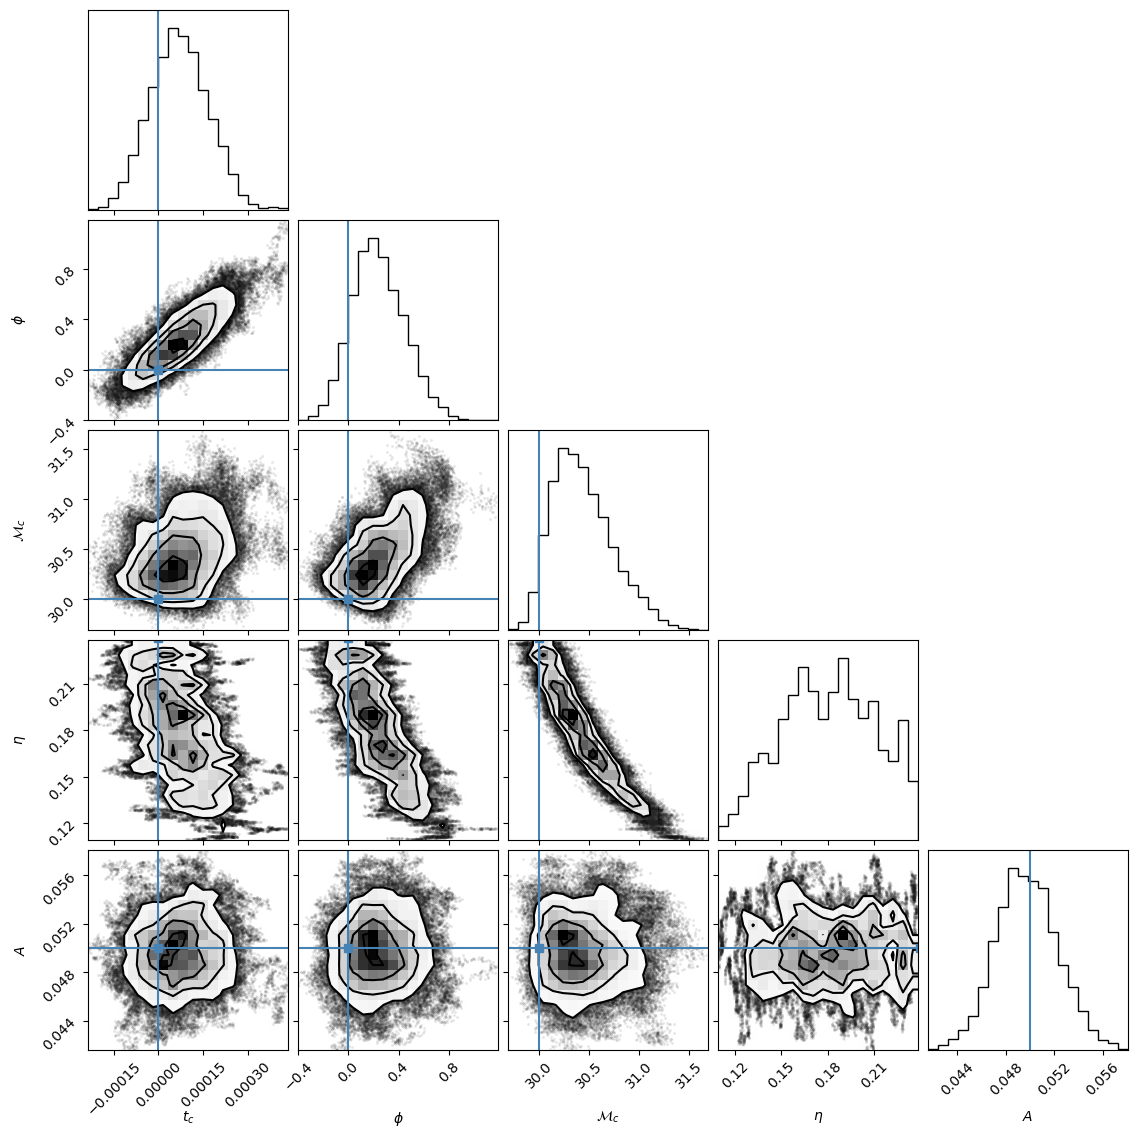

In [34]:
# For TaylorF2

# How to get samples skipped around?




fig = corner.corner(reshaped_matrix[-100000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)
# fig = corner.corner(reshaped_matrix[jnp.arange(-200000, -1, 5)], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)


# For Hybrid Rosenbrock
# labels = [r'$x_{%i}$' % (i+1) for i in range(model.DoF)]
# fig = corner.corner(reshaped_matrix[-250000:], hist_kwargs={'density':True}, labels=labels)
# corner.corner(bounded_iid_samples[-30000:], color='r', fig=fig, hist_kwargs={'density':True})


In [17]:
# JAX version of birth-death

# @partial(jax.jit, static_argnums=(1, 2))

# from src.reparameterization import reparameterization, logit, sigma_inv
# For TaylorF2 birth death on CPU

# pot = jax.vmap(model.gradient_potential_single)

# for i in range(10):
#     sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), 100, eps, X0)

#     Y, V_Y, _ = reparameterization(sam[-1], pot(sam[-1]), 1, model.lower_bound, model.upper_bound)
#     gram = k_lp(Y)

#     key, subkey = jax.random.split(key)
#     idx, _ = birthDeathJumpIndicies(key, gram, V_Y)
#     # idx, _ = birthDeathJumpIndicies(sam[-1], k_lp, jax.vmap(model.potential_single))
#     X0 = sam[-1][idx]

def birthDeathJumpIndicies(key, kern_bd, V, tau=0.01):
    """ 
    Remarks
    -------

    (1) Uses discrepancy from original paper
    (2) uses discrepancy from sequal paper

    """
    nParticles = V.shape[0]

    # Get particles with significant mass discrepancy (1)
    # beta = jnp.log(jnp.mean(kern_bd, axis=1)) + V
    # Lambda = beta - jnp.mean(beta) 

    # Get particles with significant mass discrepancy (2)
    tmp1 = jnp.mean(kern_bd, axis=1)
    Lambda = jnp.log(tmp1) + V
    Lambda = Lambda - jnp.mean(Lambda) - 1 + jnp.mean(kern_bd / tmp1, axis=1)

    # Calculate number of events
    r = jax.random.uniform(minval=0, maxval=1, shape=Lambda.shape, key=key)
    xi = jax.random.shuffle(key, jnp.argwhere(r < 1 - jnp.exp(-jnp.abs(Lambda) * tau), size=nParticles, fill_value=-1))

    # Particle jumps
    alive = jnp.full(nParticles, True)
    output = jnp.arange(nParticles)
    n_events = 0
    for i in xi:
        if i != -1 and alive[i]:
            n_events += 1
            if Lambda[i] > 0:
                alive[i] = False 
                j = jax.random.choice(key, jnp.arange(nParticles), p=alive)
                output[i] = j

            elif Lambda[i] < 0:
                alive[i] = False 
                j = jax.random.choice(key, jnp.arange(nParticles), p=alive)
                alive[i] = True 
                alive[j] = False
                output[j] = i 

    return output, n_events